In [1]:
from analysis import iso_in_plots, aesthetic_plot, PRAnalysis
from betaplus import SB, MB
import fitPRd
from kernel import VG

import numpy as np
import matplotlib.pyplot as plt


import cProfile
profiler = cProfile.Profile()

from scipy.stats import entropy, wasserstein_distance

def compute_divergences(p, q, XX):
    # p and q are the distributions (y values) corresponding to the same x values
    eps = 1e-10
    p = p + eps
    q = q + eps
    p_norm = p / np.sum(p)
    q_norm = q / np.sum(q)
    
    # Compute KL divergence in both directions
    kl_pq = entropy(p_norm, q_norm)  # KL divergence D(P || Q)
    kl_qp = entropy(q_norm, p_norm)  # KL divergence D(Q || P)
    
    # Compute the Wasserstein distance using the common x-axis: XX.
    # The Wasserstein function takes distributions along with the positions
    ws = wasserstein_distance(XX, XX, p_norm, q_norm)
    
    return kl_pq, kl_qp, ws

# Simulate kernels

In [ ]:
import inputs, simuls

## PenEasy MOD

In [ ]:
pid = 'MOD'
ver = '20'
# Initialize PenEasy Input Editor
peneasy_inps = inputs.PenEasy(verbose=True)

# Initialize Simulators (identified by pid)
peneasy_sims = simuls.PenEasy(verbose=True)
peneasy_sims.activate_pid(pid, ver)

penEasy 2020 SPC activated


In [ ]:
MATS = {'water' : ['water', 1, 1.00+00]}
SIZE = [20]*3
STEP = [0.3]*3  #cm
nhist = "1e6"

peneasy_inps.edit_voxSize(pid, SIZE, STEP)
peneasy_inps.edit_seed(pid, 12345, 54321)
peneasy_inps.edit_mat(pid, MATS, SIZE, STEP)
peneasy_inps.edit_source_nhist(pid, nhist)

"penEasy/pen??_spc.in" and "penEasy/pen??_nuc.in" coordinates of box center modified to (3, 3, 3)
"penEasy/phantomN.vox" voxel size modified to (0.3, 0.3, 0.3)
"penEasy/pen*.in" random seeds modified to 12345 and 54321
"penEasy/pen??_spc.in" and "penEasy/pen??_nuc.in" material modified to water
"penEasy/phantomN.vox" density modified to 1.00000000E+00
"penEasy/phantomN.vox" updated to water (case 1)
"penEasy/pen??_spc.in" and "penEasy/pen??_nuc.in" number of histories modified to 1e6
"penEasy/phantomN.vox" updated to point source of activity 1e6


In [ ]:
isotopes = ["C11", "N13", "O15", "F18", "Cu64", "Ga68", "Rb82", "I124"]

peneasy_inps.verbose = False
for iso in isotopes:
    print(f"Simulating {iso}")
    res_folder = f"RESULTS/SPC/Water/PenEasy20{ver}_xyz"
    peneasy_inps.edit_isotope(pid, iso)
    peneasy_sims.simulate(pid, get_times=True, time_samples=1, output_dir=res_folder, final_file=f"{iso}.dat.original")

Simulating C11
penEasy 2020 SPC real time: 119.208 +- 0.000 s
Simulating N13
penEasy 2020 SPC real time: 123.496 +- 0.000 s
Simulating O15
penEasy 2020 SPC real time: 132.084 +- 0.000 s
Simulating F18
penEasy 2020 SPC real time: 110.684 +- 0.000 s
Simulating Cu64
penEasy 2020 SPC real time: 113.591 +- 0.000 s
Simulating Ga68
penEasy 2020 SPC real time: 135.293 +- 0.000 s
Simulating Rb82
penEasy 2020 SPC real time: 150.687 +- 0.000 s
Simulating I124
penEasy 2020 SPC real time: 135.245 +- 0.000 s


In [ ]:
res_folder = f"RESULTS/SPC/Water/PenEasy20{ver}_xyz"
times_file = res_folder + "/" + pid + "_times.txt"
times = np.loadtxt(times_file).astype("str")
times[:,1], times[:,0] = times[:,0], isotopes
np.savetxt(times_file, times, fmt='%s')

# Compare against kernel from simulation

Isotope: F18
	Maximum kernel PR in x-axis: 10.25 mm
	Maximum simulated PR: 2.50 mm
	90% yield simulated PR: 0.79 mm
	99% yield simulated PR: 1.25 mm
	Voxel step size: 0.50 mm


100%|██████████| 34460/34460 [00:03<00:00, 11378.17it/s]


	From x=0 to |x|=r_99.0%:
		RMSE: 0.17 mm-1
		Maximum deviation: 26.97%
		R2: -inf
Isotope: Ga68
	Maximum kernel PR in x-axis: 10.25 mm
	Maximum simulated PR: 9.55 mm
	90% yield simulated PR: 4.45 mm
	99% yield simulated PR: 6.37 mm
	Voxel step size: 0.50 mm


100%|██████████| 34460/34460 [00:03<00:00, 9968.87it/s] 


	From x=0 to |x|=r_99.0%:
		RMSE: 0.01 mm-1
		Maximum deviation: 11.65%
		R2: 0.80
Isotope: Rb82
	Maximum kernel PR in x-axis: 10.25 mm
	Maximum simulated PR: 16.86 mm
	90% yield simulated PR: 9.03 mm
	99% yield simulated PR: 12.51 mm
	Voxel step size: 0.50 mm


100%|██████████| 34460/34460 [00:03<00:00, 9547.42it/s]


	From x=0 to |x|=r_99.0%:
		RMSE: 0.00 mm-1
		Maximum deviation: 5.70%
		R2: 0.95


100%|██████████| 34460/34460 [00:44<00:00, 778.90it/s]


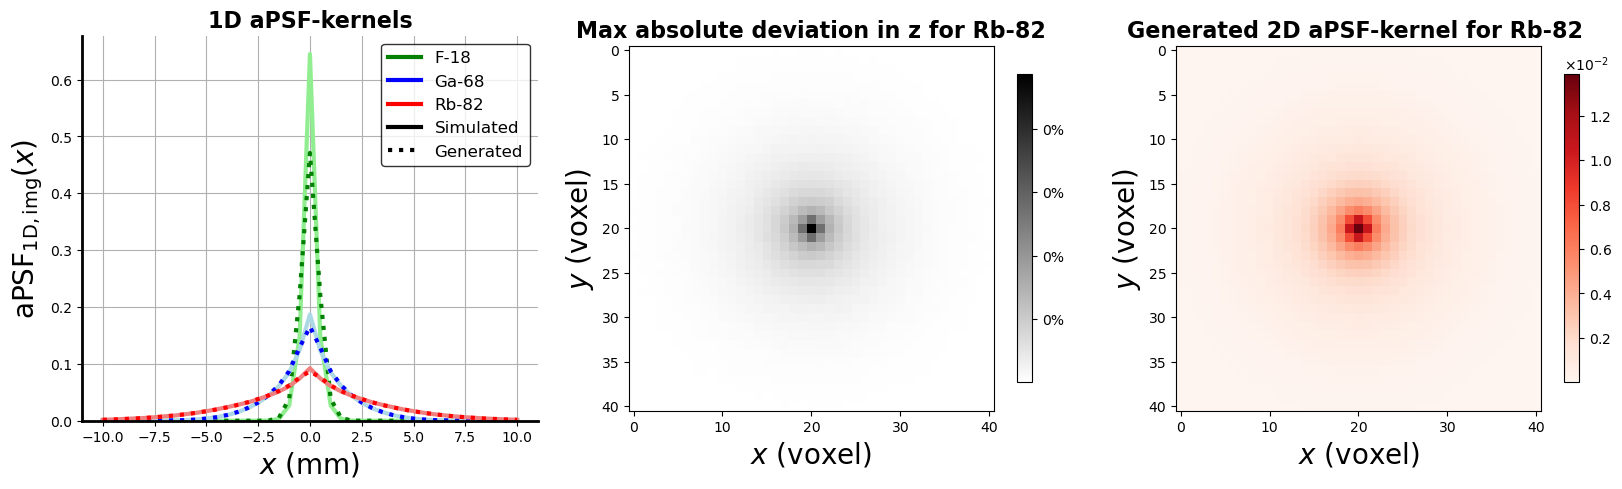

In [8]:
import matplotlib.ticker as ticker
def fmt(x, pos):
    a, b = '{:.2f}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

def get_params(_iso, _fitFile):
    _params = []
    with open(_fitFile, "r") as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith(_iso):
                _params = [float(x) for x in line.split()[4:]]
                break
    return _params

pfolder = "PenEasy2024_xyz"
fitFile_preffix = "SPC"
fitFile_suffix = "n_is_param"
kernel_size = [41]*3
kernel_step = [50e-2/10]*3 # voxel size in cm

colors1 = ['g', 'b', 'r', 'c', 'm']
colors2 = ['lightgreen', 'lightblue', 'lightcoral', 'paleturquoise', 'violet']
colors = list(zip(colors1, colors2))
isotopes = ["C11", "N13", "O15", "F18", "Cu64", "Ga68", "Rb82", "I124"]  # , "Ga68", "Rb82"
isos2plot = ["F18", "Ga68", "Rb82"]
isotopes = isos2plot
iso_colors = dict(zip(isos2plot, colors))

plt.figure(figsize=(20, 5))
for iso in isotopes:
    data_file = f"RESULTS/SPC/Water/{pfolder}/{iso}.dat"
    simul_data = PRAnalysis(f"{iso} {pfolder}", data_file, SIZE=kernel_size, STEP=kernel_step) 
    xdata = simul_data.xp*10
    real_aPSFx = simul_data.aPSFx

    print(f"Isotope: {iso}")
    print(f"\tMaximum kernel PR in x-axis: {simul_data.Xmax*10:.2f} mm")
    print(f"\tMaximum simulated PR: {simul_data.rmax*10:.2f} mm")
    print(f"\t90% yield simulated PR: {simul_data.interpol_G3D(0.9)*10:.2f} mm")
    print(f"\t99% yield simulated PR: {simul_data.interpol_G3D(0.99)*10:.2f} mm")
    print(f"\tVoxel step size: {kernel_step[0]*10:.2f} mm")

    # Get fitting parameters
    if iso in SB.keys():
        fit_file = f"RESULTS/SPC/Water/{pfolder}/{fitFile_preffix}-sb_fit-{fitFile_suffix}.txt"
        fit_func, argsP, argsC = fitPRd.MBfit_function(100)
        params = get_params(iso, fit_file)

    elif iso in MB.keys():
        fit_file = f"RESULTS/MB/Water/{pfolder}/{fitFile_preffix}-mb_fit-{fitFile_suffix}.txt"
        weights = [b[3]*100 for b in MB[iso]['branches']]
        fit_func, argsP, argsC = fitPRd.MBfit_function(*weights)
        params = []
        for i in range(len(weights)):
            isob = f"{iso}-b{i+1}"
            params += get_params(isob, fit_file)

    fit_func.fitted_params = params
    aPSF3D_tmp = fit_func.get_aPSF3D()
    rmin = 1e-8
    aPSF3D = lambda _r: aPSF3D_tmp(np.where(_r < rmin, rmin, _r))
    aPSF_kernel_VG = VG(aPSF3D, kernel_step, kernel_size, rlim=(rmin, None), voxel_griding=5, source_griding=1)

    plt.subplot(131)
    kernel_aPSFx = np.sum(aPSF_kernel_VG, axis=(1, 2))
    kernel_aPSFx /= kernel_aPSFx.sum()
    real_aPSFx /= real_aPSFx.sum()
    XX = simul_data.aPSFx_range*10

    rmask = 0.99
    mask = abs(XX) <= simul_data.interpol_G3D(rmask)
    res = kernel_aPSFx - real_aPSFx
    print(f"\tFrom x=0 to |x|=r_{rmask*100}%:")

    rmse = np.sqrt(np.sum(res[mask]**2) / len(res[mask]))
    print(f"\t\tRMSE: {rmse:.2f} mm-1")

    deviation = np.abs(res[mask] / real_aPSFx[mask]) * 100
    print(f"\t\tMaximum deviation: {deviation.max():.2f}%")

    r2 = 1.0 - np.sum(res[mask]**2) / np.sum((real_aPSFx[mask]-np.mean(real_aPSFx[mask]))**2)
    print(f"\t\tR2: {r2:.2f}")

    # plt.plot(simul_data.aPSFx_range[mask]*10, deviation, label=f"{iso_in_plots(iso)}")
    if iso not in isos2plot: continue
    real_aPSFx /= real_aPSFx.sum()
    kernel_aPSFx /= kernel_aPSFx.sum()
    plt.plot(XX, real_aPSFx, '-', color=iso_colors[iso][1])
    plt.plot(XX, kernel_aPSFx, ':', color=iso_colors[iso][0])
plt.xlabel(r"$x$ (mm)")
plt.ylabel(r"$\mathrm{aPSF}_\mathrm{1D,img}(x)$")
for iso in isos2plot:
    plt.plot([], [] , label=iso_in_plots(iso), color=iso_colors[iso][0])
plt.plot([], [] , '-', label="Simulated", color='black')
plt.plot([], [] , ':', label="Generated", color='black')
plt.legend(ncols=2)
ax, leg = aesthetic_plot(legend_size=12, linewidth=3)
ax.set_title("1D aPSF-kernels", fontsize=16, fontweight='bold')

plt.subplot(132)
simul_data.img /= simul_data.img.sum()
aPSF_kernel_VG /= aPSF_kernel_VG.sum()

sfactor = 1e3
simul_data.img *= sfactor
aPSF_kernel_VG *= sfactor

res = aPSF_kernel_VG - simul_data.img

res_z = np.sum(res**2, axis=2)
rmse_z = np.sqrt(res_z / (kernel_size[2]))

y = np.sum(simul_data.img, axis=2)
r2_xy = 1.0 - np.sum(res_z**2) / (y - np.mean(y))**2

tol = 0
dev = np.abs( res/ (simul_data.img+tol) ) #* 100

plt.imshow(np.mean(np.abs(res), axis=2), cmap='binary', interpolation='nearest')
plt.xlabel(r"$x$ (voxel)", fontsize=20)
plt.ylabel(r"$y$ (voxel)", fontsize=20)
cbar = plt.colorbar(shrink=0.8)
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}%'))
# cbar.ax.yaxis.set_offset_position('left')
# cbar.formatter.set_powerlimits((0, 0))
# cbar.formatter.set_useMathText(True)
plt.title(f"Max absolute deviation in z for {iso_in_plots(iso)}", fontsize=16, fontweight='bold')

plt.subplot(133)
aPSF_kernel_VG = VG(aPSF3D, kernel_step, kernel_size, rlim=(rmin, None), voxel_griding=5, source_griding=3)
plt.imshow(np.sum(aPSF_kernel_VG, axis=2), cmap='Reds', interpolation='nearest')
plt.xlabel(r"$x$ (voxel)", fontsize=20)
plt.ylabel(r"$y$ (voxel)", fontsize=20)
cbar = plt.colorbar(shrink=0.8)
# cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}%'))
cbar.ax.yaxis.set_offset_position('left')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
plt.title(f"Generated 2D aPSF-kernel for {iso_in_plots(iso)} ", fontsize=16, fontweight='bold')
plt.show()

In [9]:
def get_params(_iso, _fitFile):
    _params = []
    with open(_fitFile, "r") as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith(_iso):
                _params = [float(x) for x in line.split()[4:]]
                break
    return _params

pfolder = "PenEasy2024_xyz"
fitFile_preffix = "SPC"
fitFile_suffix = "n_is_param"
kernel_specs = {
    "C11" :([41]*3, [.10/10]*3), # voxel size in cm
    "N13" :([41]*3, [.15/10]*3), # voxel size in cm
    "O15" :([41]*3, [.25/10]*3), # voxel size in cm
    "F18" :([41]*3, [.05/10]*3), # voxel size in cm
    "Cu64":([41]*3, [.10/10]*3), # voxel size in cm
    "Ga68":([41]*3, [.30/10]*3), # voxel size in cm
    "Rb82":([41]*3, [.50/10]*3), # voxel size in cm
    "I124":([41]*3, [.35/10]*3), # voxel size in cm
}

isotopes = ["C11", "N13", "O15", "F18", "Cu64", "Ga68", "Rb82", "I124"]  # , "Ga68", "Rb82"
print_final_table = False
if print_final_table:
    print(r"\begin{table}[H]")
    print(r"\centering")
    print(r"\begin{tabular}{|c|c|c|c|c|c|c|c|}")
    print(r"\toprule")
    print(r"Isotope & Kernel size & Voxel size (mm) & 90\% yield PR (mm) & 99\% yield PR (mm) & RMSE (mm$^{-1}$) & Max. deviation (\%) & R$^2$ \\")
    print(r"\midrule")

for iso in isotopes:
    data_file = f"RESULTS/SPC/Water/{pfolder}/{iso}.dat"
    kernel_size, kernel_step = kernel_specs[iso]
    simul_data = PRAnalysis(f"{iso} {pfolder}", data_file, SIZE=kernel_size, STEP=kernel_step) 
    xdata = simul_data.xp*10
    real_aPSFx = simul_data.aPSFx

    if not print_final_table:
        print(f"Isotope: {iso}")
        print(f"\tVoxel step size: {kernel_step[0]*10:.2f} mm")
        print(f"\tMaximum kernel PR in x-axis: {simul_data.Xmax*10:.2f} mm")
        print(f"\tMaximum simulated PR: {simul_data.rmax*10:.2f} mm")
        print(f"\t90% yield simulated PR: {simul_data.interpol_G3D(0.9)*10:.2f} mm")
        print(f"\t99% yield simulated PR: {simul_data.interpol_G3D(0.99)*10:.2f} mm")

    # Get fitting parameters
    if iso in SB.keys():
        fit_file = f"RESULTS/SPC/Water/{pfolder}/{fitFile_preffix}-sb_fit-{fitFile_suffix}.txt"
        fit_func, argsP, argsC = fitPRd.MBfit_function(100)
        params = get_params(iso, fit_file)

    elif iso in MB.keys():
        fit_file = f"RESULTS/MB/Water/{pfolder}/{fitFile_preffix}-mb_fit-{fitFile_suffix}.txt"
        weights = [b[3]*100 for b in MB[iso]['branches']]
        fit_func, argsP, argsC = fitPRd.MBfit_function(*weights)
        params = []
        for i in range(len(weights)):
            isob = f"{iso}-b{i+1}"
            params += get_params(isob, fit_file)

    fit_func.fitted_params = params
    aPSF3D_tmp = fit_func.get_aPSF3D()
    rmin = 1e-8
    aPSF3D = lambda _r: aPSF3D_tmp(np.where(_r < rmin, rmin, _r))
    aPSF_kernel_VG = VG(aPSF3D, kernel_step, kernel_size, rlim=(rmin, None), voxel_griding=3, source_griding=1, disable_tqdm=(True if print_final_table else False))

    kernel_aPSFx = np.sum(aPSF_kernel_VG, axis=(1, 2))
    kernel_aPSFx /= kernel_aPSFx.sum()
    real_aPSFx /= real_aPSFx.sum()
    XX = simul_data.aPSFx_range*10

    rmask = 0.99
    mask = abs(XX) <= simul_data.interpol_G3D(rmask)
    res = kernel_aPSFx - real_aPSFx

    rmse = np.sqrt(np.sum(res[mask]**2) / len(res[mask]))
    deviation = np.abs(res[mask] / real_aPSFx[mask]) * 100
    r2 = 1.0 - np.sum(res[mask]**2) / np.sum((real_aPSFx[mask]-np.mean(real_aPSFx[mask]))**2)

    if not print_final_table:
        print(f"\tFrom x=0 to |x|=r_{rmask*100}%:")
        print(f"\t\tRMSE: {rmse:.2f} mm-1")
        print(f"\t\tMaximum deviation: {deviation.max():.2f}%")
        print(f"\t\tR2: {r2:.2f}")
        kl_kernel_real, kl_real_kernel, ws_distance = compute_divergences(kernel_aPSFx, real_aPSFx, XX)
        print("KL divergence (kernel || real):", kl_kernel_real)
        print("KL divergence (real || kernel):", kl_real_kernel)
        print("Wasserstein distance:", ws_distance)
    else:
        print(f"{iso} & {kernel_size[0]:.2f} & {kernel_step[0]*10:.2f} & {simul_data.interpol_G3D(0.9)*10:.2f} & {simul_data.interpol_G3D(0.99)*10:.2f} & {rmse:.2f} & {deviation.max():.2f} & {r2:.2f} \\\\")

if print_final_table:
    print(r"\bottomrule")
    print(r"\end{tabular}")
    print(r"\caption{Summary of the isotopes simulated with PenEasy.}")
    print(r"\label{tab:summary}")
    print(r"\end{table}")

Isotope: C11
	Voxel step size: 0.10 mm
	Maximum kernel PR in x-axis: 2.05 mm
	Maximum simulated PR: 4.16 mm
	90% yield simulated PR: 1.83 mm
	99% yield simulated PR: 2.76 mm


100%|██████████| 34460/34460 [00:02<00:00, 11543.58it/s]


	From x=0 to |x|=r_99.0%:
		RMSE: 0.01 mm-1
		Maximum deviation: 19.05%
		R2: 0.82
KL divergence (kernel || real): 0.0036915956013367423
KL divergence (real || kernel): 0.0038926712607444606
Wasserstein distance: 0.0078114893788441605
Isotope: N13
	Voxel step size: 0.15 mm
	Maximum kernel PR in x-axis: 3.08 mm
	Maximum simulated PR: 5.54 mm
	90% yield simulated PR: 2.49 mm
	99% yield simulated PR: 3.68 mm


100%|██████████| 34460/34460 [00:02<00:00, 11609.74it/s]


	From x=0 to |x|=r_99.0%:
		RMSE: 0.01 mm-1
		Maximum deviation: 17.85%
		R2: 0.84
KL divergence (kernel || real): 0.003044432834931783
KL divergence (real || kernel): 0.0032082908316809636
Wasserstein distance: 0.01388012326370203
Isotope: O15
	Voxel step size: 0.25 mm
	Maximum kernel PR in x-axis: 5.13 mm
	Maximum simulated PR: 8.71 mm
	90% yield simulated PR: 4.07 mm
	99% yield simulated PR: 5.82 mm


100%|██████████| 34460/34460 [00:02<00:00, 11810.98it/s]


	From x=0 to |x|=r_99.0%:
		RMSE: 0.01 mm-1
		Maximum deviation: 15.15%
		R2: 0.85
KL divergence (kernel || real): 0.0019450325511194614
KL divergence (real || kernel): 0.0020306331253422097
Wasserstein distance: 0.01533389959628727
Isotope: F18
	Voxel step size: 0.05 mm
	Maximum kernel PR in x-axis: 1.03 mm
	Maximum simulated PR: 2.50 mm
	90% yield simulated PR: 1.01 mm
	99% yield simulated PR: 1.57 mm


100%|██████████| 34460/34460 [00:02<00:00, 11879.20it/s]


	From x=0 to |x|=r_99.0%:
		RMSE: 0.01 mm-1
		Maximum deviation: 17.93%
		R2: 0.89
KL divergence (kernel || real): 0.003535739195044528
KL divergence (real || kernel): 0.003696060113558761
Wasserstein distance: 0.004092818661305949
Isotope: Cu64
	Voxel step size: 0.10 mm
	Maximum kernel PR in x-axis: 2.05 mm
	Maximum simulated PR: 2.59 mm
	90% yield simulated PR: 1.07 mm
	99% yield simulated PR: 1.63 mm


100%|██████████| 34460/34460 [00:02<00:00, 12102.54it/s]


	From x=0 to |x|=r_99.0%:
		RMSE: 0.02 mm-1
		Maximum deviation: 13.98%
		R2: 0.76
KL divergence (kernel || real): 0.002372632105814687
KL divergence (real || kernel): 0.002465340818259842
Wasserstein distance: 0.00864789513040921
Isotope: Ga68
	Voxel step size: 0.30 mm
	Maximum kernel PR in x-axis: 6.15 mm
	Maximum simulated PR: 9.55 mm
	90% yield simulated PR: 4.59 mm
	99% yield simulated PR: 6.48 mm


100%|██████████| 34460/34460 [00:03<00:00, 10490.01it/s]


	From x=0 to |x|=r_99.0%:
		RMSE: 0.01 mm-1
		Maximum deviation: 9.76%
		R2: 0.92
KL divergence (kernel || real): 0.0007297989184465727
KL divergence (real || kernel): 0.0007496942092379182
Wasserstein distance: 0.009552702688000451
Isotope: Rb82
	Voxel step size: 0.50 mm
	Maximum kernel PR in x-axis: 10.25 mm
	Maximum simulated PR: 16.86 mm
	90% yield simulated PR: 9.03 mm
	99% yield simulated PR: 12.51 mm


100%|██████████| 34460/34460 [00:03<00:00, 10135.27it/s]


	From x=0 to |x|=r_99.0%:
		RMSE: 0.00 mm-1
		Maximum deviation: 6.18%
		R2: 0.94
KL divergence (kernel || real): 0.0002940304624677461
KL divergence (real || kernel): 0.0002978763023874923
Wasserstein distance: 0.0165560716001859
Isotope: I124
	Voxel step size: 0.35 mm
	Maximum kernel PR in x-axis: 7.17 mm
	Maximum simulated PR: 10.19 mm
	90% yield simulated PR: 4.72 mm
	99% yield simulated PR: 7.22 mm


100%|██████████| 34460/34460 [00:03<00:00, 9879.22it/s] 

	From x=0 to |x|=r_99.0%:
		RMSE: 0.00 mm-1
		Maximum deviation: 6.60%
		R2: 0.96
KL divergence (kernel || real): 0.00042702824451187513
KL divergence (real || kernel): 0.0004331832965387305
Wasserstein distance: 0.00752549039599512
